---
title: "Dimensionality Reduction"
---

# Objective
The objective of this section will be to try and reduce the number of features in our dataset while simultaneously retaining as much information as possible. Our exploration into dimensionality reduction will serve as the basis for further machine learning algorithims in this project by helping us spot "irrelevant" and/or redundant features in our data. We will be performing two seperate dimensionality reduction analyses with a set of numerical features and also categorical features. The bulk of analysis in this section will be completed using scikit-learn package under Python.

# Principal Component Analysis (PCA)
## Preparing our data for PCA

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# Reading in our data
horses = pd.read_csv('../../../data/01-modified-data/horses.clean.csv')
perf = pd.read_csv('../../../data/01-modified-data/perf.clean.no.error.csv')

/tmp/ipykernel_355532/915142976.py:3: DtypeWarning: Columns (10,18,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  perf = pd.read_csv('../../../data/01-modified-data/perf.clean.no.error.csv')


In [3]:
# Need to join color, sex, and import type with perf data. Then, create a race_length variable, along with a column that outputs 1 or 0 for podium finish.
# Data can then be cleaned to only include features of interest.

perf_clean = pd.merge(perf,horses[["horse_id","colour","sex","import_type"]],on="horse_id",how = "inner")

For PCA, we are only interested in our numerical variables. For our categorical variables, we will be performing mutliple correspondence analysis (MCA) (see following section). We will be including discrete numerical variables with the caveat that PCA is best and primarily suited for continous, numerical variables. Using discrete data in PCA may pose some problems like violations of distributional assumptions as PCA does not take into to account assumptions of non-normality in the data (see https://staskolenikov.net/talks/Gustavo-Stas-PCA-generic.pdf).  Such violations definitely poses an issue with a variable like 'draw' in our data which, in theory, follows a uniform distribution. Also, if a variable has high kurtosis or skewness, the variable is going to have different asymptotic properties that could impact our interpretation of our principal components. Due to these different asymptotic properties, the PCA values in our eigenvector values for our discrete features may be much lower than our continous features, even if the discrete features do, in "ground truth", explain a significant portion of variance in our data.

The authors of the paper listed above state that these problems are not major, but do need to be considered when interpreting principal components. The authors do list seperate techniques of dimensionality reduction for discrete features (i.e. Filmer-Pritchett procedure, polychoric PCA, and group means), but for the sake of this project, I will be doing a typical PCA with both my discrete and continous numericals in my feature set, taking into account that the discrete features might have lower PCA values.

In [12]:
# Adding in podium finish as a target variable
perf_clean['podium'] = np.nan
for i in range(len(perf_clean["final_placing"])):   
    if perf_clean["final_placing"][i] == 1 or perf_clean["final_placing"][i] == 2 or perf_clean["final_placing"][i] == 3:
        perf_clean['podium'][i] = 1
    else:
        perf_clean['podium'][i] = 0

/tmp/ipykernel_355532/3691484775.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_clean['podium'][i] = 0
/tmp/ipykernel_355532/3691484775.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perf_clean['podium'][i] = 1


In [13]:
# All relevant numerical features including
perf_numerical = perf_clean[['rating','actual_weight','on_date_weight','draw','average_placement','days_between', 'podium']]
perf_numerical = perf_numerical.dropna()

Now we are going to standardize our data and peform PCA.

In [15]:
# Normalize feature set
perf_num_features = perf_numerical.iloc[:, :-1]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(perf_num_features)

In [19]:
# PCA
pca = PCA()
pca.fit(scaled_data)
cov_matrix = pca.get_covariance()
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_

print("Covariance Matrix:")
print(cov_matrix)

print("\nEigenvalues:")
print(eigenvalues)

print("\nEigenvectors:")
print(eigenvectors)



Covariance Matrix:
[[ 1.00000574  0.16812366  0.15552332 -0.02631532 -0.43889779  0.01146646]
 [ 0.16812366  1.00000574  0.04296327  0.00109719 -0.14074245  0.0101492 ]
 [ 0.15552332  0.04296327  1.00000574 -0.00917871 -0.14289013  0.02713919]
 [-0.02631532  0.00109719 -0.00917871  1.00000574  0.01588906  0.00257841]
 [-0.43889779 -0.14074245 -0.14289013  0.01588906  1.00000574 -0.00136074]
 [ 0.01146646  0.0101492   0.02713919  0.00257841 -0.00136074  1.00000574]]

Eigenvalues:
[1.60560626 1.00677582 0.99946662 0.9526173  0.87588313 0.5596853 ]

Eigenvectors:
[[-0.62733661 -0.34080662 -0.33228691  0.04763382  0.61358235 -0.03365643]
 [-0.05315568 -0.01428587  0.21171307  0.41376421  0.06857758  0.88104725]
 [-0.02164703 -0.20350403  0.16461573 -0.88991496  0.04338487  0.37038937]
 [-0.00129095  0.67569924 -0.67056052 -0.17257946  0.03796183  0.25010535]
 [ 0.29344057 -0.61894347 -0.60620044  0.06696241 -0.36899233  0.15060986]
 [ 0.71905884 -0.05071864 -0.02311411  0.01771769  0.69234

Above, the eigenvector matrix displays our main piece of interest for PCA. Each column represents a principal component, with the first column representing PC1. Each row in the matrix represents the following variables, respectively: 'rating','actual_weight','on_date_weight','draw','average_placement','days_between'. 

Before we begin to dissect our PC values, we must define how many PC's should be of our interest. Using the Kaiser criterion, we should only be considering PC's with corresponding eigenvalues that are greater than 1. In our case, our third PC is just barely under 1 and the 4th is not too far behind. Therefore, knowing what we know about our inclusion of discrete features, in order to make sure we are not discluding relevant information, we are going to be looking at at least the first 4 PC's. We can confirm our choice with the Scree Plot down below.

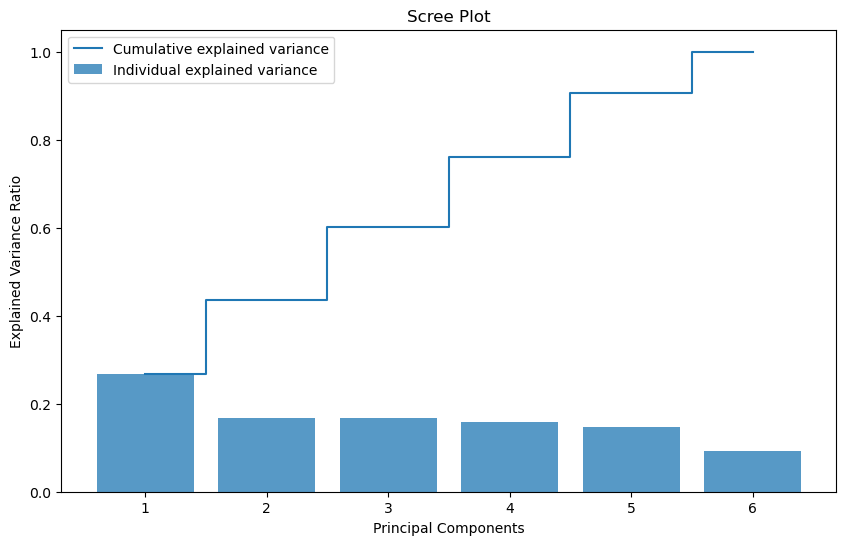

In [17]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.75, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.show()

In this plot, we can see that the first five principal components actually seem to propogate the most explained variance. For this reason, we will include the fifth PC into our analysis as well.

## Analysis of Principal Components
Looking at the first principal component, it is clear there are two main features that explain most of the variance in the data: the amount of rest days between a horse's race and horse rating. Their values in our matrix of eigenvectors are approximately 0.719 and -0.627, repectively, showing they vary inversely. These variables can be considered the most "important" of our numeric feature set.

In our second principal component, we can see two features with values of 0.676 and -0.619, respectively: draw and average placement before the race. These features can be seen as our "second most important" features.

In our third prinicipal component, draw and average placement also stand out as features, this time posting values of -0.671 and -0.606.

Our fourth principal component showss on date weight (which does not include the gear a horse is wearing) as a standout feature with a value of -0.890. We can see actual weight, which is the weight of a horse's gear, showing a value of 0.414 which certainly is somewhat novel, but given that it does not really exceed an "eyeball" test of being above the threshold of 0.5 and on date weight is the main standout feature of this PC, we can likely disregard actual weight.

Our fifth principal component shows rating (0.614) and days of rest between races (0.692) as the most heavily weighted. We have already seen both of these features as the most heavily weighted in previous PCs so the fifth PC really is not giving us any "new" information.

Upon this analysis, we can see that we most likely disregard "actual weight" as a feature in our dataset. Dropping this feature will provide some more simplicity to our analyses in future sections. It is interesting to see that the rest of the features explain a significant portion of the variance in our numerical feature set. Most interesting to me is how days of rest between races presented itself as such a significant feature, especially given this is a feature we derived ourselves during data cleaning. Horse rating being such an important feature does make sense as it is sort of a "catch all" metric of past performance by a horse that measures and synthesizes an amalgamation of features relating to a horse's past race performance. 

Below is a plot that helps us visualize our dataset compared with our target variable of podium finish.

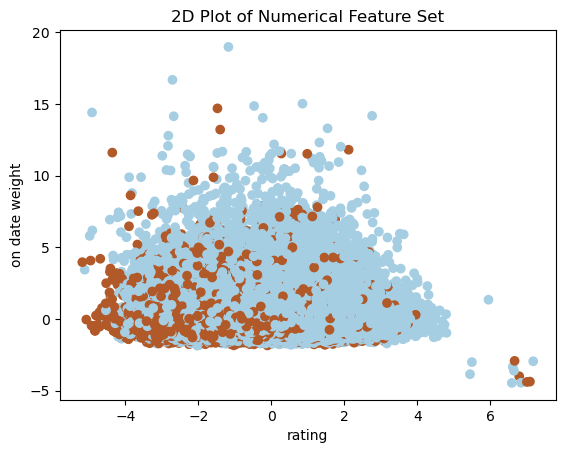

In [25]:
X1 = pca.fit_transform(scaled_data)
Y = perf_numerical['podium']

#2D PLOT
plt.scatter(X1[:,0], X1[:,1], c=Y, cmap='Paired')
plt.xlabel("rating")
plt.ylabel("on date weight")
plt.title("2D Plot of Numerical Feature Set")
plt.show()

# Multiple Correspondence Analysis
I will complete this section at a later time, but I want to use MCA to explore categorical variables. For the sake of time in the completion of Homework 4, I will tackle this later.

# T-distributed Stochastic Neighbor Embedding (t-SNE)
*Adapted from ["How to Use t-SNE Effectively"](https://distill.pub/2016/misread-tsne/)*

t-SNE is a method for visualizing high-dimensional data in a low-dimensional space. The main tuneable parameter of t-SNE is "perplexity" which essentially guides us on how much attention to pay attention to the local and global characteristics of our data. For datasets that are larger (like our dataset), larger perplexity values are needed (50+). We will take a look at our data with a wide range of perplexity values.

In [26]:
from sklearn.manifold import TSNE

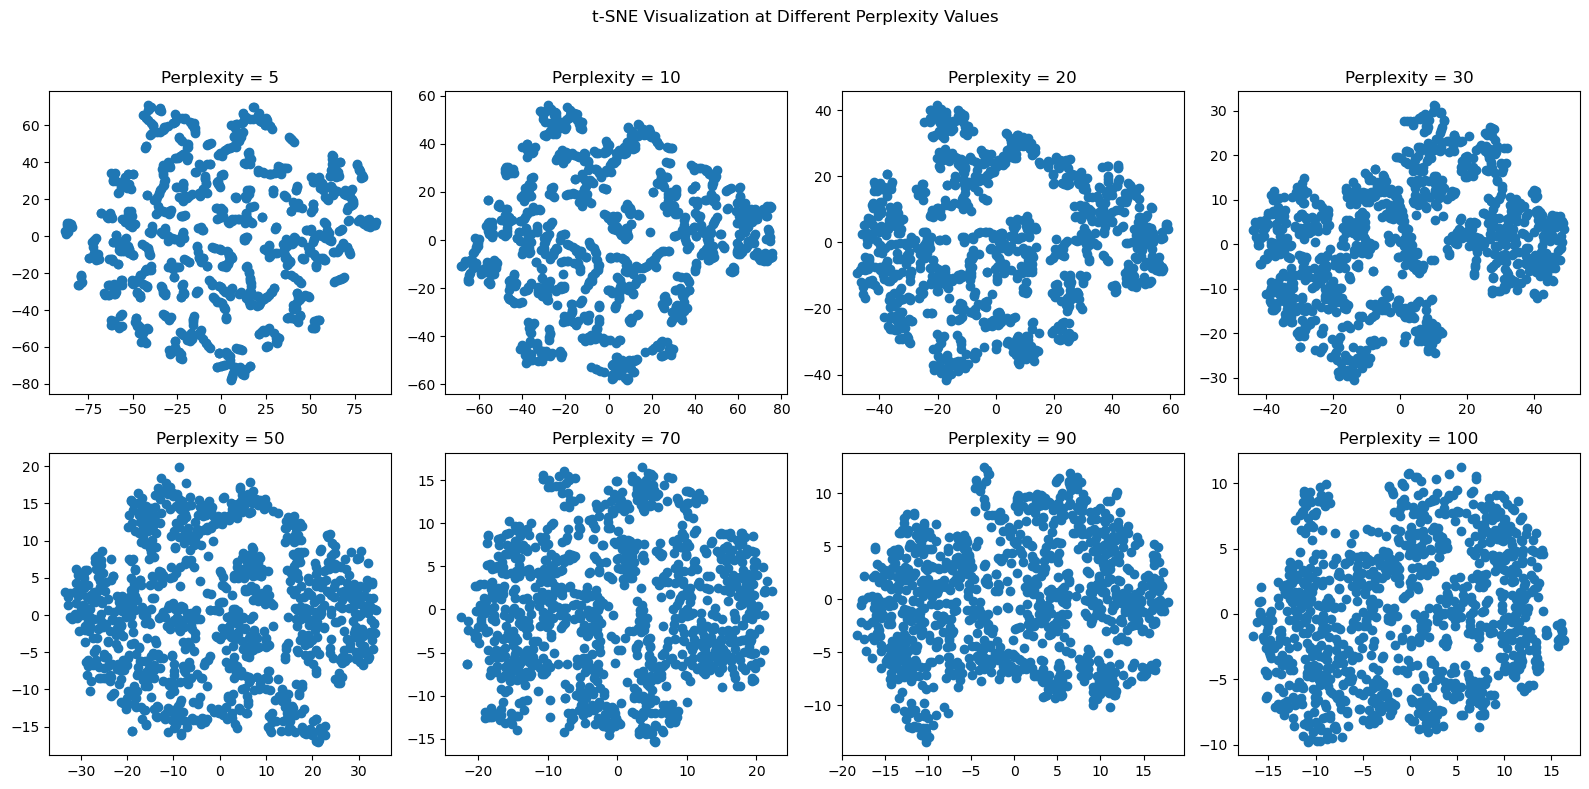

In [34]:
# Creating t-SNE visualizations for perplexity values 5, 10, 20, 30, 50, 70, and 100
perplexities = [5, 10, 20, 30, 50, 70, 90, 100]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('t-SNE Visualization at Different Perplexity Values')

for i, perplexity in enumerate(perplexities):
    # Create a t-SNE instance with 2 components (for 2D visualization) and the current perplexity value
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

    # Fit and transform the data
    X_tsne = tsne.fit_transform(scaled_data[:1000,])

    # Results for the i-th subplot
    ax = axes[i // 4, i % 4]
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1])
    ax.set_title(f'Perplexity = {perplexity}')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

For each of the perplexity values, as we get into perplexities above 50, our datapoints start to turn into what looks like one sphere. What this evenly distributed, spherical shape is telling us is that our data is most like uniformly distributed. It might appear to be random noise, but according to our source *"How to Use t-SNE Effectively"*, such a conclusion is far from the truth. As we begin to turn up our perplexity and our visualization starts to really reveal this spherical distribution of data, we see that the density of data points is mostly consistent, with a few deviations in density here and there. These deviations are for us to try and pinpoint in further sections, but overall, our numerical feature set demonstrates that there is a uniform distribution of each of the features, which intuitively makes sense as every horse race is esentially repeated sampling of an elite pool of race horses that are only going to deviate in genetic makeup (i.e. weight) and statistics, like days of rest and average placement, to certain, small extent.


# Comparisons and Conclusions
Overall, through PCA and t-SNE, we are able to garner a few major takeawawys. For one, despite the linear assumptions PCA uses, t-SNE tells us that these assumptions of linearity might not neccesarily be true for our data. Our data truly might be uniformly distributed, making assumptions of linearity somewhat moot when performing PCA, meaning that PCA might not be reliably selecting orthogonal directions that capture maximum variance (aka our eigenvectors). Despite this caveat, it should be said that t-SNE does show deviations from a completely and truly uniform distributed set of spatial data, allowing us to assume there is some variance at play within our dataset that can be analyzed through PCA.

When we use PCA, looking at the first five principal components, we do see that that we have some features that are better at explaining the variance of our data, with horse rating and days of rest between races being the most significant of our variables. Draw and average placement came out to be our next most "important" variables, with the rest of the variables, except for actual weight, also showing some sort of significant explanation of the variance in the feature set. 

It is with all these takeaways that we are able to establish some statistically sound explanations of patterns in our data and what variables most heavily dictate a horse's performance. We will begin to use this information in the next section, Clustering, to help us interpret results from various clustering algorithims.